In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pickle

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


# PyTorch Data Importing
https://dev.to/mariazentsova/how-to-load-data-from-s3-to-aws-sagemaker-mea

In [4]:
import boto3
s3 = boto3.resource('s3')
bucket = s3.Bucket('cassava-images')

In [5]:
for item in bucket.objects.all():
    print(item)

s3.ObjectSummary(bucket_name='cassava-images', key='train.csv')
s3.ObjectSummary(bucket_name='cassava-images', key='train_images.zip')


In [6]:
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket = 'cassava-images', Key='train.csv')
images_df = pd.read_csv('s3://cassava-images/train.csv')

In [7]:
images_df.head(5)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
from io import BytesIO
from zipfile import ZipFile

obj = bucket.Object('train_images.zip')
bytes_ = BytesIO(obj.get()["Body"].read())
z = ZipFile(bytes_)

In [9]:
file = z.open('100042118.jpg')
data = Image.open(file)

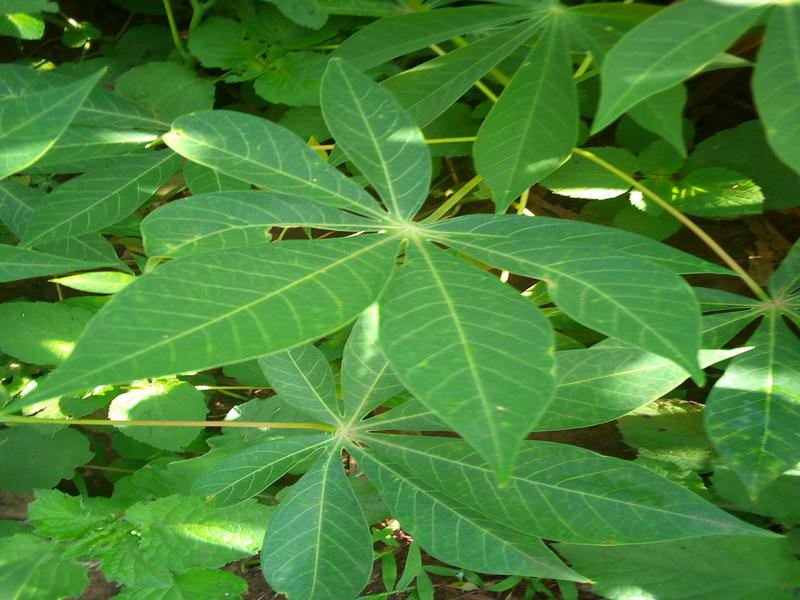

In [9]:
data

# Exploratory Data Analysis

Text(0.5, 1.0, 'Label counts in the dataset')

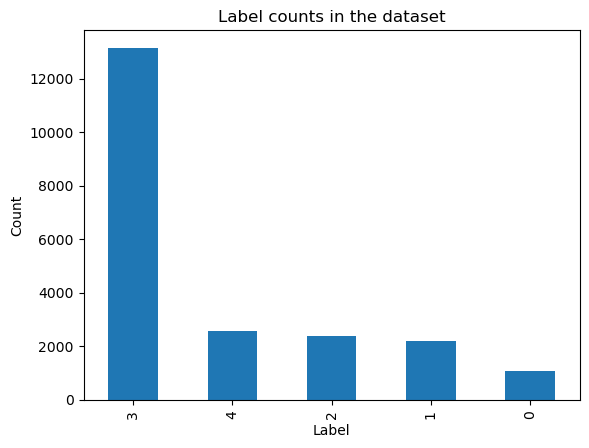

In [9]:
images_df['label'].value_counts().plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label counts in the dataset")

There is a clear label imbalance in our dataset, which means we need to use techniques to take this into account.

In [10]:
ENCODING_TO_LABEL = {
    0: "Bacterial Blight (CBB)",
    1: "Brown Streak Disease (CBSD)",
    2: "Green Mottle (CGM)",
    3: "Mosaic Disease (CMD)",
    4: "Healthy"
                    }
LABEL_TO_ENCODING = {
    "Bacterial Blight (CBB)": 0,
    "Brown Streak Disease (CBSD)": 1,
    "Green Mottle (CGM)": 2,
    "Mosaic Disease (CMD)": 3,
    "Healthy": 4
}

# Data Loader Class

In [11]:
class CASDataset(Dataset):
    
    def __init__(self, z, labels, transform=None):
        """
        z:         ZipFile containing the images
        labels:    pandas dataframe [image_id, label]
        transform: Some function to apply transformations to the dataset
        """
        self.z = z
        self.labels = labels.reset_index()
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.labels['image_id'].at[idx]
        
        image = Image.open(z.open(img_name))
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels['label'].at[idx]
        
        return (image, label)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Resize((224, 224))
])

In [13]:
from sklearn.model_selection import train_test_split

# Generates a 0.6, 0.2, 0.2 Train, Val, Test split

train_df, test_df = train_test_split(images_df, test_size = 0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state=42)

In [14]:
train_df.head(10)

,image_id,label
13753,3459805310.jpg,3
18365,439346642.jpg,1
1263,1220597062.jpg,3
16020,3882757126.jpg,0
19951,72014881.jpg,4
13705,3453071010.jpg,4
13530,3418761424.jpg,3
10986,295733469.jpg,4
3939,1700592380.jpg,3
8357,2484373271.jpg,1


In [15]:
train_dataset = CASDataset(z, train_df, transform=transform)
test_dataset = CASDataset(z, test_df, transform=transform)
val_dataset = CASDataset(z, val_df, transform=transform)

# Visualisation of dataset

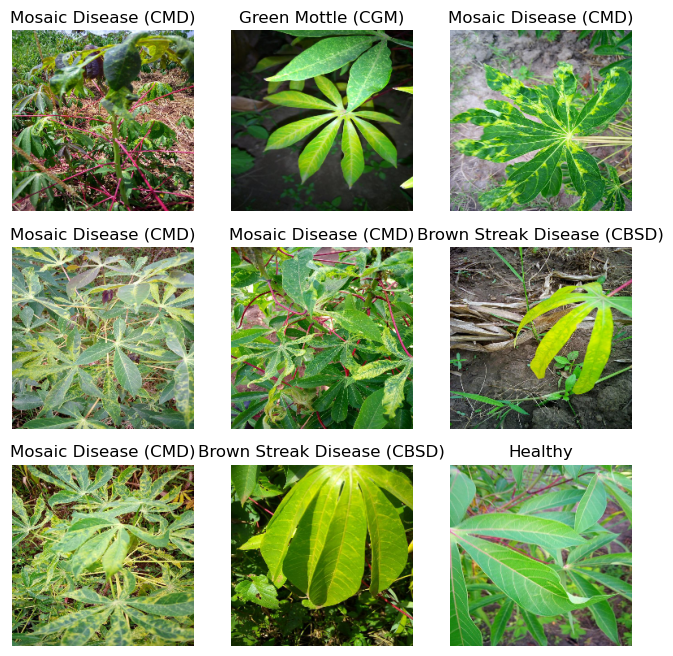

In [16]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(42)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ENCODING_TO_LABEL[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
plt.show()

# Data Loaders

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Network
We use a standard CNN approach, and we used focal loss in order to minimise the effect of our imbalanced dataset.

In [17]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

## Network Module

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # (3, 224, 224)
        self.conv1 = nn.Conv2d(3, 32, 6, stride=2)
        # (32, 110, 110)
        self.maxpool1 = nn.MaxPool2d(4, stride=2)
        # (32, 54, 54)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        # (64, 26, 26)
        self.maxpool2 = nn.MaxPool2d(3, stride=1)
        # (64, 24, 24)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1)
        # (128, 22, 22)
        self.maxpool3 = nn.MaxPool2d(2, stride=1)
        # (128, 21, 21)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2)
        # (256, 10, 10)
        self.maxpool4 = nn.MaxPool2d(3, stride=1)
        # (256, 8, 8)
        self.conv5 = nn.Conv2d(256, 256, 3, stride=1)
        # (256, 6, 6)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1)
        # (256, 4, 4)
        
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)
    
    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = self.maxpool3(F.relu(self.conv3(x)))
        x = self.maxpool4(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

### Training Loop

In [19]:
def train_net(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=25):
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 

        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Zero the gradients out
            optimizer.zero_grad()

            # 4. Get the loss
            loss = criterion(predictions, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update the weights
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_dataloader))
        train_acc.append(correct/total)

        model.eval()
        running_loss = 0.
        correct, total = 0, 0 

        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Get the loss
            loss = criterion(predictions, labels)

            running_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_loss.append(running_loss / len(val_dataloader)) 
        validation_acc.append(correct/total)

        print(f"Epoch {epoch+1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Validation Loss:", round(validation_loss[epoch], 3))

        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

        print("------------------------------")
    return train_loss, validation_loss, train_acc, validation_acc


In [47]:
init_model = Net().to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25)

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99)
optimizer = optim.Adam(init_model.parameters(), lr=0.001, betas=(0.9, 0.99))

In [48]:
ce_train_loss, ce_val_loss, ce_train_acc, ce_val_acc = train_net(
    init_model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=10
)

Epoch 1:
Training Loss: 1.082
Validation Loss: 0.953
Training Accuracy: 0.625
Validation Accuracy: 0.639
------------------------------
Epoch 2:
Training Loss: 0.974
Validation Loss: 0.91
Training Accuracy: 0.641
Validation Accuracy: 0.659
------------------------------
Epoch 3:
Training Loss: 0.947
Validation Loss: 0.892
Training Accuracy: 0.647
Validation Accuracy: 0.666
------------------------------
Epoch 4:
Training Loss: 0.895
Validation Loss: 0.838
Training Accuracy: 0.662
Validation Accuracy: 0.685
------------------------------
Epoch 5:
Training Loss: 0.854
Validation Loss: 0.868
Training Accuracy: 0.676
Validation Accuracy: 0.685
------------------------------
Epoch 6:
Training Loss: 0.838
Validation Loss: 0.838
Training Accuracy: 0.682
Validation Accuracy: 0.684
------------------------------
Epoch 7:
Training Loss: 0.825
Validation Loss: 0.808
Training Accuracy: 0.685
Validation Accuracy: 0.692
------------------------------
Epoch 8:
Training Loss: 0.806
Validation Loss: 0.

In [ ]:
torch.save(init_model, "init_model.pt")

In [21]:
plt.plot(list(range(30)), ce_train_loss, label = 'Train')
plt.plot(list(range(30)), ce_val_loss, label = 'Test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Cross entropy loss of custom CNN")

NameError: name 'ce_train_loss' is not defined

In [ ]:
plt.plot(list(range(30)), ce_train_acc, label = 'Train')
plt.plot(list(range(30)), ce_val_acc, label = 'Test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Cross entropy loss trained accuracy of custom CNN")

### Evaluation of initial model on test set


In [20]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [21]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix

In [22]:
def get_conf(model, dataloader):
    conf_matrix = torch.zeros((5, 5))

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Get the model predictions
        predictions = model(inputs)

        _, predicted = torch.max(predictions, 1)

        conf_matrix += multiclass_confusion_matrix(predicted, labels, 5).to(device="cpu")
    
    return conf_matrix

In [23]:
def get_f1_scores(conf_matrix, num_labels):
    f1_scores = torch.zeros(num_labels)
    for i in range(num_labels):
        tp = conf_matrix[i, i]
        fp = torch.sum(conf_matrix[i, :]) - tp
        fn = torch.sum(conf_matrix[:, i]) - tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1_scores[i] = 2 * precision * recall / (precision + recall)
    return f1_scores

In [24]:
def get_accuracy(conf_matrix):
    return torch.sum(torch.diagonal(conf_matrix, 0)) / torch.sum(conf_matrix)

In [101]:
conf_matrix = get_conf(init_model, test_dataloader)

In [118]:
conf_matrix

tensor([[  16.,   39.,    5.,   33.,  117.],
        [   9.,  129.,    5.,  176.,  116.],
        [   3.,   21.,   31.,  288.,  121.],
        [   0.,   29.,   14., 2582.,   49.],
        [   8.,   27.,   27.,  169.,  266.]])

In [116]:
get_accuracy(conf_matrix)

tensor(0.7065)

In [117]:
get_f1_scores(conf_matrix, 5)

tensor([0.1301, 0.3794, 0.1136, 0.8720, 0.4563])

## Focal Loss Model
https://github.com/clcarwin/focal_loss_pytorch/blob/e11e75bad957aecf641db6998a1016204722c1bb/focalloss.py#L6

In [ ]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target.reshape((1, -1)))
        
        logpt = logpt.view(-1)
        pt = torch.exp(logpt)

        loss = -self.alpha * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [25]:
!pip install balanced-loss

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 1.7 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.11.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.2 which is incompatible.


In [73]:
class_counts = torch.tensor(test_df['label'].value_counts().sort_index())

In [85]:
from balanced_loss import Loss

torch.manual_seed(10)

focal_model = Net().to(device)

# criterion = FocalLoss(gamma=5, alpha=0.25)
# criterion = nn.CrossEntropyLoss()
criterion = Loss(loss_type="focal_loss")

optimizer = optim.Adam(focal_model.parameters(), lr=0.001, betas=(0.9, 0.99))

In [86]:
fl_train_loss, fl_val_loss, fl_train_acc, fl_val_acc = train_net(
    focal_model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=12
)

Epoch 1:
Training Loss: 0.48
Validation Loss: 0.454
Training Accuracy: 0.619
Validation Accuracy: 0.637
------------------------------
Epoch 2:
Training Loss: 0.431
Validation Loss: 0.415
Training Accuracy: 0.635
Validation Accuracy: 0.642
------------------------------
Epoch 3:
Training Loss: 0.416
Validation Loss: 0.437
Training Accuracy: 0.646
Validation Accuracy: 0.652
------------------------------
Epoch 4:
Training Loss: 0.399
Validation Loss: 0.38
Training Accuracy: 0.655
Validation Accuracy: 0.669
------------------------------
Epoch 5:
Training Loss: 0.383
Validation Loss: 0.367
Training Accuracy: 0.669
Validation Accuracy: 0.676
------------------------------
Epoch 6:
Training Loss: 0.373
Validation Loss: 0.363
Training Accuracy: 0.674
Validation Accuracy: 0.677
------------------------------
Epoch 7:
Training Loss: 0.36
Validation Loss: 0.354
Training Accuracy: 0.684
Validation Accuracy: 0.706
------------------------------
Epoch 8:
Training Loss: 0.354
Validation Loss: 0.35

In [87]:
torch.save(focal_model, "focal_model.pt")

Text(0.5, 1.0, 'Focal loss of custom CNN (Adam)')

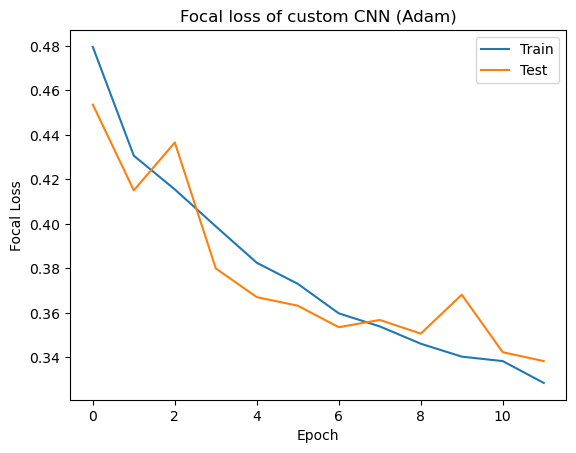

In [109]:
plt.plot(list(range(12)), fl_train_loss, label = 'Train')
plt.plot(list(range(12)), fl_val_loss, label = 'Test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.title("Focal loss of custom CNN (Adam)")

Text(0.5, 1.0, 'Focal loss trained accuracy of custom CNN (Adam)')

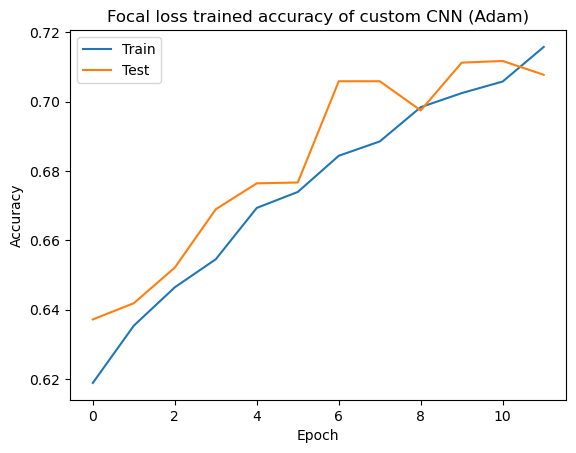

In [111]:
plt.plot(list(range(12)), fl_train_acc, label = 'Train')
plt.plot(list(range(12)), fl_val_acc, label = 'Test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Focal loss trained accuracy of custom CNN (Adam)")

In [90]:
focal_model = torch.load("focal_model.pt")

### Evaluation of Focal Loss Model

In [91]:
conf_matrix_f = get_conf(focal_model, test_dataloader)

In [92]:
conf_matrix_f

tensor([[ 105.,   17.,    7.,   28.,   53.],
        [  86.,  154.,    9.,  100.,   86.],
        [  16.,   22.,   59.,  205.,  162.],
        [   8.,   70.,   51., 2453.,   92.],
        [  72.,   18.,   34.,  103.,  270.]])

In [93]:
get_f1_scores(conf_matrix_f, 5)

tensor([0.4225, 0.4302, 0.1891, 0.8819, 0.4655])

In [94]:
get_accuracy(conf_matrix_f)

tensor(0.7105)

In [95]:
conf_matrix_f_shift = get_conf(focal_model, test_shift_dataloader)
conf_matrix_f_shift

tensor([[4.0000e+01, 8.6000e+01, 0.0000e+00, 3.6000e+01, 4.8000e+01],
        [1.6000e+01, 2.5400e+02, 1.0000e+00, 7.9000e+01, 8.5000e+01],
        [7.0000e+00, 1.3500e+02, 5.0000e+00, 2.1200e+02, 1.0500e+02],
        [6.0000e+00, 7.3600e+02, 7.0000e+00, 1.7680e+03, 1.5700e+02],
        [2.1000e+01, 1.5100e+02, 3.0000e+00, 1.4900e+02, 1.7300e+02]])

In [96]:
get_f1_scores(conf_matrix_f_shift, 5)

tensor([0.2667, 0.2827, 0.0208, 0.7190, 0.3249])

In [97]:
get_accuracy(conf_matrix_f_shift)

tensor(0.5234)

## Distribution Shifts

In [52]:
torch.manual_seed(10)

shift_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(5),
    transforms.ColorJitter(brightness=0.2)
])

In [53]:
train_shift_dataset = CASDataset(z, train_df, transform=shift_transform)
test_shift_dataset = CASDataset(z, test_df, transform=shift_transform)
val_shift_dataset = CASDataset(z, val_df, transform=shift_transform)

In [54]:
train_shift_dataloader = DataLoader(train_shift_dataset, batch_size = 32, shuffle=True)
val_shift_dataloader = DataLoader(val_shift_dataset, batch_size=32, shuffle=True) 
test_shift_dataloader = DataLoader(test_shift_dataset, batch_size=32, shuffle=False)

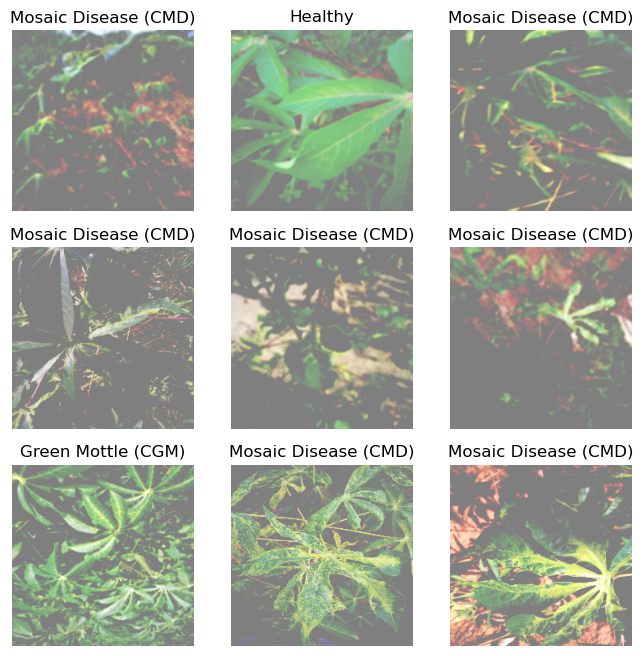

In [55]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(42)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_shift_dataset), size=(1,)).item()
    img, label = train_shift_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ENCODING_TO_LABEL[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
plt.show()

### Initial Model on shifted test dataset

In [62]:
init_model = torch.load("init_model.pt")

In [63]:
conf_matrix = get_conf(init_model, test_shift_dataloader)

In [67]:
conf_matrix.int()

tensor([[   0,   52,    2,   68,   88],
        [   0,   89,    9,  197,  140],
        [   0,   34,   17,  296,  117],
        [   0,  105,   46, 2317,  206],
        [   1,   50,   13,  232,  201]], dtype=torch.int32)

In [65]:
get_f1_scores(conf_matrix, 5)

tensor([   nan, 0.2327, 0.0617, 0.8012, 0.3219])

In [66]:
get_accuracy(conf_matrix)

tensor(0.6131)

## Training on shifted dataset

In [100]:
from balanced_loss import Loss

shift_model = Net().to(device)

criterion = Loss(loss_type="focal_loss")

optimizer = optim.Adam(shift_model.parameters(), lr=0.001, betas=(0.9, 0.99))

In [ ]:
s_train_loss, s_val_loss, s_train_acc, s_val_acc = train_net(
    shift_model, criterion, optimizer, train_shift_dataloader, val_shift_dataloader, num_epochs=15
)

Epoch 1:
Training Loss: 0.487
Validation Loss: 0.457
Training Accuracy: 0.616
Validation Accuracy: 0.615
------------------------------
Epoch 2:
Training Loss: 0.456
Validation Loss: 0.43
Training Accuracy: 0.624
Validation Accuracy: 0.639
------------------------------
Epoch 3:
Training Loss: 0.442
Validation Loss: 0.412
Training Accuracy: 0.633
Validation Accuracy: 0.65
------------------------------
Epoch 4:
Training Loss: 0.43
Validation Loss: 0.467
Training Accuracy: 0.637
Validation Accuracy: 0.609
------------------------------
Epoch 5:
Training Loss: 0.425
Validation Loss: 0.409
Training Accuracy: 0.643
Validation Accuracy: 0.654
------------------------------
Epoch 6:
Training Loss: 0.417
Validation Loss: 0.406
Training Accuracy: 0.644
Validation Accuracy: 0.646
------------------------------
Epoch 7:
Training Loss: 0.415
Validation Loss: 0.396
Training Accuracy: 0.644
Validation Accuracy: 0.658
------------------------------
Epoch 8:
Training Loss: 0.412
Validation Loss: 0.42

In [ ]:
torch.save(shift_model, "shift_model.pt")

### Shifted Model Evaluation

In [ ]:
conf_matrix = get_conf(shift_model, test_shift_dataloader)

In [115]:
conf_matrix.int()

tensor([[  84,   16,    0,   67,   43],
        [  65,   78,    1,  198,   93],
        [  14,   12,    0,  354,   84],
        [   8,   32,    5, 2597,   32],
        [  71,   38,    0,  241,  147]], dtype=torch.int32)

In [ ]:
get_f1_scores(conf_matrix, 5)

tensor([0.3717, 0.2553,    nan, 0.8472, 0.3281])

In [ ]:
get_accuracy(conf_matrix)

tensor(0.6790)

In [ ]:
conf_matrix_1 = get_conf(shift_model, test_dataloader)

In [ ]:
get_f1_scores(conf_matrix_1 ,5)

tensor([0.1289, 0.0617,    nan, 0.3248, 0.1069])

In [ ]:
get_accuracy(conf_matrix_1)

tensor(0.1911)

In [116]:
conf_matrix_1.int()

tensor([[ 172,   15,    0,   13,   10],
        [ 348,   27,    0,   32,   28],
        [ 226,   58,    0,   87,   93],
        [1398,  299,    0,  560,  417],
        [ 315,   41,    0,   82,   59]], dtype=torch.int32)